In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, distinct

In [5]:
from flask import Flask, jsonify

In [6]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [8]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)
conn = engine.connect()

# Precipitation Analysis

In [11]:
# Review Measurement data as a dictionary
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x26022b8b0f0>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [12]:
# Review Station data as a dictionary
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x26022b8b898>,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'station': 'USC00519397',
 'elevation': 3.0,
 'latitude': 21.2716,
 'id': 1}

In [13]:
# Convert Measurement into Pandas DataFrame
measurement_df = pd.read_sql("SELECT * FROM Measurement", conn)
measurement_df.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [14]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date

('2017-08-23')

In [15]:
# Using this date, retrieve the last 12 months of precipitation data by querying the 12 preceding months of data.
most_recent_date = dt.date(2017, 8 ,23)
last_12_months = most_recent_date - dt.timedelta(days=365)
last_12_months

datetime.date(2016, 8, 23)

In [16]:
# Perform a query to retrieve the data and precipitation scores (Select only the date and prcp values)
date_prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date.between(last_12_months, most_recent_date)).all()

# Load the query results into a Pandas DataFrame and set the index to the date column.
# Sort the DataFrame values by date. 
date_prcp_df = pd.DataFrame(date_prcp).set_index("date")
date_prcp_df = date_prcp_df.sort_values("date").dropna()

date_prcp_df.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70


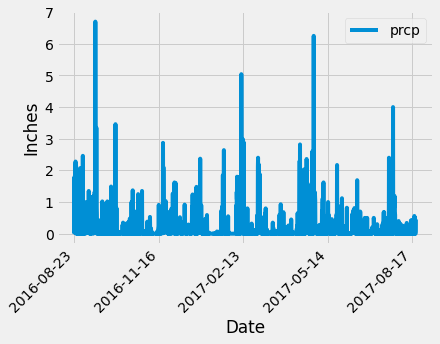

In [17]:
# Plot the results using the DataFrame plot method.
date_prcp_df.plot(y = "prcp")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.xticks(rotation = "45", horizontalalignment = "right")
plt.savefig("Images/Precipitation Analysis.png")
plt.show()

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
date_prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [19]:
# Design a query to calculate the total number stations in the dataset
station_number = session.query(distinct(Measurement.station)).count()
print(f'There are total of {station_number} stations in the dateset.')

There are total of 9 stations in the dateset.


In [20]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and observation counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Which station id has the highest number of observations?
print(f"The most active station is {active_stations[0][0]}.")

The most active station is USC00519281.


In [22]:
# Using the most active station id, calculate the lowest, highest, and average temperature.
lowest_tobs = session.query(func.min(Measurement.tobs)).filter(Measurement.station == "USC00519281").scalar()
highest_tobs = session.query(func.max(Measurement.tobs)).filter(Measurement.station == "USC00519281").scalar()
avg_tobs = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == "USC00519281").scalar()

multiline_str = (
f"The Lowest Temperature: {lowest_tobs}\n"
f"The Highest Temperature: {highest_tobs}\n"
f"The Average Temperature: {avg_tobs: 2f}\n"
)
print(multiline_str, end="")

The Lowest Temperature: 54.0
The Highest Temperature: 85.0
The Average Temperature:  71.663781


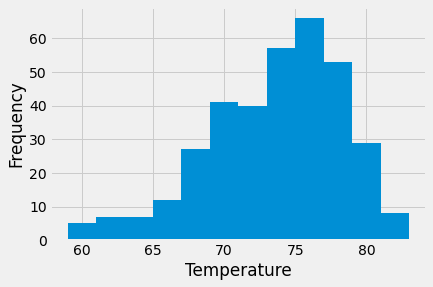

In [23]:
# Design a query to retrieve the last 12 months of temperature observation data (TOBS).
# Filter by the station with the highest number of observations.
# Query the last 12 months of temperature observation data for this station.
# Plot the results as a histogram with bins=12.
date_tobs = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == "USC00519281").\
    filter(Measurement.date.between(last_12_months, most_recent_date)).all()
date_tobs_df = pd.DataFrame(date_tobs).set_index("date")
plt.hist(date_tobs_df["tobs"], bins = 12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.savefig("Images/Station Analysis.png")
plt.show()

# Close session

In [24]:
# Close Session
session.close()

# Temperature Analysis I

In [43]:
import pandas as pd
from datetime import datetime as dt

In [26]:
# "tobs" is "temperature observations"
df = pd.read_csv('Resources/hawaii_measurements.csv')
df.head()

,station,date,prcp,tobs
0,USC00519397,2010-01-01,0.08,65
1,USC00519397,2010-01-02,0.00,63
2,USC00519397,2010-01-03,0.00,74
3,USC00519397,2010-01-04,0.00,76
4,USC00519397,2010-01-06,NaN,73


In [27]:
# Convert the date column format from string to datetime

In [28]:
# Set the date column as the DataFrame index
index_df = pd.DataFrame(df).set_index("date").dropna()
index_df.head()

,station,prcp,tobs
date,,,
2010-01-01,USC00519397,0.08,65
2010-01-02,USC00519397,0.00,63
2010-01-03,USC00519397,0.00,74
2010-01-04,USC00519397,0.00,76
2010-01-07,USC00519397,0.06,70


In [29]:
# Drop the date column

## Compare June and December data across all years 

In [30]:
from scipy import stats

In [31]:
# Filter data for desired months
# Identify the average temperature for June
june_temp = session.query(Measurement.station, func.avg(Measurement.tobs)).\
    filter(func.strftime("%m", Measurement.date) == "06").\
    group_by(Measurement.station).all()
june_temp_df = pd.DataFrame(june_temp, columns = ["station", "tavg_june"])
june_average = june_temp_df["tavg_june"].mean()
print(f"Average temperature for June is {june_average}")

Average temperature for June is 74.85351018249018


In [32]:
# Identify the average temperature for December
dec_temp = session.query(Measurement.station, func.avg(Measurement.tobs)).\
    filter(func.strftime("%m", Measurement.date) == "12").\
    group_by(Measurement.station).all()
dec_temp_df = pd.DataFrame(dec_temp, columns = ["station", "tavg_dec"])
dec_average = dec_temp_df["tavg_dec"].mean()
print(f"Average temperature for December is {dec_average}")

Average temperature for December is 71.21907046377945


In [33]:
# Run paired t-test
from scipy.stats import ttest_ind
stat, p = ttest_ind(june_temp_df["tavg_june"], dec_temp_df["tavg_dec"])
print("t=%.3f, p=%.3f" % (stat, p))

t=4.616, p=0.000


## Analysis

The difference in the means of temperatures in June vs December are statistically significant

# Temperature Analysis II

In [34]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [35]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax for a year in the data set
print(calc_temps('2011-02-28', '2011-03-05'))
tmin, tavg, tmax = calc_temps('2011-02-28', '2011-03-05')[0]

[(61.0, 69.75510204081633, 75.0)]


C:\Users\h-torihara\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


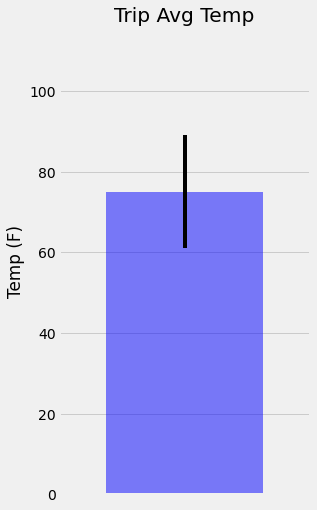

In [36]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize=plt.figaspect(2.))
yerr = tmax-tmin
ax.bar(1, tmax, yerr=yerr, alpha=0.5, color='blue', align="center")
ax.set(xticks=range(1), xticklabels="a", title="Trip Avg Temp", ylabel="Temp (F)")
ax.margins(.3, .3)
plt.savefig("Images/Trip Avg Temp.png")
fig.show()

## Daily Rainfall Average

In [37]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

In [38]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

## Daily Temperature Normal

In [39]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
date_list = pd.date_range(start_date, end_date).tolist()

# Strip off the year and save a list of strings in the format %m-%d
date_str_list = [date_list[i].strftime("%m-%d") for i in range(len(date_list))]

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
for i in range(len(date_str_list)):
    daily_normal = list(np.ravel(daily_normals(date_str_list[i])))
    normals.append(daily_normal)
normals

[[67.0, 75.54, 83.0],
 [68.0, 75.60377358490567, 84.0],
 [70.0, 76.61111111111111, 85.0],
 [69.0, 76.71153846153847, 84.0],
 [69.0, 76.14814814814815, 82.0],
 [67.0, 76.25, 83.0],
 [71.0, 77.15686274509804, 83.0]]

In [40]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns = ["tmin", "tavg", "tmax"])
normals_df["date"] = date_list
normals_df.set_index("date", inplace = True)
normals_df

,tmin,tavg,tmax
date,,,
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0


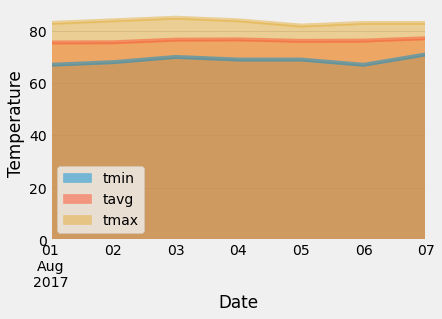

In [41]:
# Plot the daily normals as an area plot with `stacked=False`
ax = normals_df.plot.area(stacked = False)
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.savefig("Images/Daily Rainfall Average.png")
plt.show()

## Close Session

In [42]:
session.close()